<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 MultiplicationScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


<AxesSubplot: >

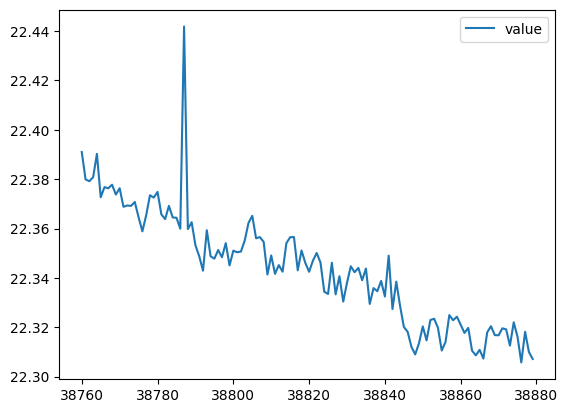

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_584835/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 2.069342765379806 %
smape 0.7204935446957519 %
smape 0.8928532804681086 %
smape 0.6381890380211115 %
smape 0.8554274702549514 %
smape 0.7271669657267112 %
smape 0.8970894669836159 %
smape 0.6747896154428157 %
smape 0.6878050445743744 %
smape 0.7229920109745513 %
smape 0.8795001655520888 %
smape 0.8445093893597164 %
smape 0.6983831208995789 %
smape 0.7823464010787 %
smape 0.7075497849040382 %
smape 0.8651935425978453 %
smape 0.8527139176077438 %
smape 0.7974476781939238 %
smape 0.8693494296469997 %
smape 0.7618262315079113 %
smape 0.7950271435687183 %
smape 0.7099270418116806 %
smape 0.720623165055189 %
smape 0.7872527151260312 %
smape 0.788143060506425 %
smape 0.7322215974298224 %
smape 0.8601580306612587 %
smape 0.6502628316561561 %
smape 0.6404702994041145 %
smape 0.7428150967053513 %
smape 0.7325738194985425 %
smape 0.7856836716735692 %
smape 0.6822573526405691 %
smape 0.7592847864589468 %
smape 0.639391725301492 %
smape 0.7533229005230967 %
smape 0.6527712349868406 %
smape 0.

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.831048098982137 %
SMAPE 0.9326288534211926 %
SMAPE 0.6101144085587293 %
SMAPE 0.4455484311183682 %
SMAPE 0.7202975722029805 %
SMAPE 0.47854662058307446 %
SMAPE 0.8556293842266314 %
SMAPE 0.36785928085919295 %
SMAPE 0.5702269738540053 %
SMAPE 0.7731133719680656 %
SMAPE 0.7261394343231586 %
SMAPE 0.9443532736768248 %
SMAPE 0.640063166996697 %
SMAPE 0.7726996859710198 %
SMAPE 0.6795126001707104 %
SMAPE 0.4617430516736932 %
SMAPE 0.5458880854421295 %
SMAPE 0.8234026526697562 %
SMAPE 0.3983135692033101 %
SMAPE 0.7075483710104891 %
SMAPE 0.743922687779559 %
SMAPE 0.7202718743064906 %
SMAPE 0.4910381741938181 %
SMAPE 0.8008884434239006 %
SMAPE 0.8275116147124207 %
SMAPE 0.7071452752479672 %
SMAPE 0.9169325744223897 %
SMAPE 0.6705989627862436 %
SMAPE 0.5303969653687091 %
SMAPE 0.4423317955602215 %
SMAPE 0.9057654070202261 %
SMAPE 0.6980308737620362 %
SMAPE 0.48235189386832644 %
SMAPE 0.8429270602209725 %
SMAPE 0.9012758415774442 %
SMAPE 0.5402520585485036 %
SMAPE 0.7385830486018676 %
S

SMAPE 0.4675725816123304 %
SMAPE 0.5286028840055224 %
SMAPE 0.49657169027705095 %
SMAPE 0.8156286268385884 %
SMAPE 0.6529869550613512 %
SMAPE 0.6841919719445286 %
SMAPE 0.43224642641143873 %
SMAPE 0.7246104144132914 %
SMAPE 0.5104066437415895 %
SMAPE 0.591427640265465 %
SMAPE 0.7353655657552736 %
SMAPE 0.5402923406072659 %
SMAPE 0.6148548712480988 %
SMAPE 0.6754737343326269 %
SMAPE 0.5393209562753327 %
SMAPE 0.43370621796202613 %
SMAPE 0.8364075776771642 %
SMAPE 0.3154311238467926 %
SMAPE 0.7797840937264482 %
SMAPE 0.683756533642736 %
SMAPE 0.6545508288982091 %
SMAPE 0.7409655444935197 %
SMAPE 0.38842669994119206 %
SMAPE 0.774339021754713 %
SMAPE 0.5926425894176646 %
SMAPE 0.5454667251760839 %
SMAPE 0.7360827363518183 %
SMAPE 0.6716533174112556 %
SMAPE 0.47593821223267696 %
SMAPE 0.813375602781889 %
SMAPE 0.29371399177762214 %
SMAPE 0.5360249050572747 %
SMAPE 0.4542606563918525 %
SMAPE 0.5485142420620832 %
SMAPE 0.5432874368598277 %
SMAPE 0.7489386680681491 %
SMAPE 0.5115394127033142 %

SMAPE 0.6842575926275458 %
SMAPE 0.2932764331326325 %
SMAPE 0.4870983148575761 %
SMAPE 0.44834209417604143 %
SMAPE 0.4348245400324231 %
SMAPE 0.5012764984330715 %
SMAPE 0.2674425087916461 %
SMAPE 0.5382732984799077 %
SMAPE 0.4193534918158548 %
SMAPE 0.560315144892229 %
SMAPE 0.4542289157907362 %
SMAPE 0.5520007359937154 %
SMAPE 0.521604764580843 %
SMAPE 0.6590525759493175 %
SMAPE 0.6254963348983438 %
SMAPE 0.5460109522318817 %
SMAPE 0.3491124963911716 %
SMAPE 0.7496761473594233 %
SMAPE 0.7724499843961894 %
SMAPE 0.6159801035537384 %
SMAPE 0.6649152186510037 %
SMAPE 0.6007982825030922 %
SMAPE 0.7862635419608068 %
SMAPE 0.5193708736624103 %
SMAPE 0.30803267587543814 %
SMAPE 0.4865722193571855 %
SMAPE 0.4744534274632315 %
SMAPE 0.4161331804641577 %
SMAPE 0.4258874861152435 %
SMAPE 0.4667155217346135 %
SMAPE 0.4876242879399797 %
SMAPE 0.34559367789915996 %
SMAPE 0.7541597075469326 %
SMAPE 0.6997771193564404 %
SMAPE 0.5963171478251752 %
SMAPE 0.6644340881612152 %
SMAPE 0.606632198265288 %
S

SMAPE 0.41063761833720497 %
SMAPE 0.47960916734700726 %
SMAPE 0.2764948751646443 %
SMAPE 0.4942502187914215 %
SMAPE 0.7479276967205806 %
SMAPE 0.36715833461312286 %
SMAPE 1.0079715823558217 %
SMAPE 0.471476517348492 %
SMAPE 0.5013102287557558 %
SMAPE 0.5972600829700241 %
SMAPE 0.45959572865558584 %
SMAPE 0.9436826125202059 %
SMAPE 0.4713619229478354 %
SMAPE 0.5067266041837684 %
SMAPE 0.8513841498424881 %
SMAPE 0.507878270054789 %
SMAPE 0.5800893969135359 %
SMAPE 0.42828094970172975 %
SMAPE 0.42788775056396844 %
SMAPE 0.6772512586248922 %
SMAPE 0.5213646602496738 %
SMAPE 0.5843252191043575 %
SMAPE 0.4854882106301374 %
SMAPE 0.611958122892247 %
SMAPE 0.4584832175642078 %
SMAPE 0.4424317651519232 %
SMAPE 0.5409618216945091 %
SMAPE 0.7351363161869813 %
SMAPE 0.3768387378331681 %
SMAPE 0.37504666574386647 %
SMAPE 0.42498277237154986 %
SMAPE 0.49434345143163233 %
SMAPE 0.596254553342078 %
SMAPE 0.4546073151013843 %
SMAPE 0.5515846198177314 %
SMAPE 0.5546083472436294 %
SMAPE 0.646561433670285

SMAPE 0.7080235658663696 %
SMAPE 0.3551690400363441 %
SMAPE 0.37599726486587315 %
SMAPE 0.46755218289763434 %
SMAPE 0.6630438580614282 %
SMAPE 0.4092839204458869 %
SMAPE 0.712141075724503 %
SMAPE 0.357344000662124 %
SMAPE 0.3773996267027542 %
SMAPE 0.38414450722666516 %
SMAPE 0.4182935187982366 %
SMAPE 0.9377008429582929 %
SMAPE 0.32174601682345383 %
SMAPE 0.4690913828899284 %
SMAPE 0.4635063644461752 %
SMAPE 0.529257448084536 %
SMAPE 0.41916040730575327 %
SMAPE 0.21842470943374792 %
SMAPE 0.4871284940163605 %
SMAPE 0.5445347000131733 %
SMAPE 0.46021834595740074 %
SMAPE 0.7175239274047271 %
SMAPE 0.350411020051979 %
SMAPE 0.3718646131892456 %
SMAPE 0.44406679285020795 %
SMAPE 0.43840075281968893 %
SMAPE 0.5751251615783985 %
SMAPE 0.46128075730302953 %
SMAPE 0.5529433643732773 %
SMAPE 0.4406667936236773 %
SMAPE 0.25410666490734 %
SMAPE 0.5817952831857838 %
SMAPE 0.5605136579979444 %
SMAPE 0.7559333370591048 %
SMAPE 0.5222028112184489 %
SMAPE 0.5874375160201453 %
SMAPE 0.4854806208168156

SMAPE 0.25831105403631227 %
SMAPE 0.4629058032242029 %
SMAPE 0.4718013733654516 %
SMAPE 0.4815099944098619 %
SMAPE 0.48330117674049683 %
SMAPE 0.5387356817809632 %
SMAPE 0.4393659890047275 %
SMAPE 0.5638957682313048 %
SMAPE 0.6651730346202385 %
SMAPE 0.47681288204330485 %
SMAPE 0.5084899236426281 %
SMAPE 0.4816271888266783 %
SMAPE 0.5035524362465367 %
SMAPE 0.5022612646134803 %
SMAPE 0.40076834710271214 %
SMAPE 0.29947342995365034 %
SMAPE 0.4648924397406518 %
SMAPE 0.5196488973651867 %
SMAPE 0.45829711653641425 %
SMAPE 0.5371670124004595 %
SMAPE 0.4261977478672634 %
SMAPE 0.40947068283276167 %
SMAPE 0.25720955645738286 %
SMAPE 0.45749520631034096 %
SMAPE 0.47633143178973114 %
SMAPE 0.4882402670918964 %
SMAPE 0.4698180308059819 %
SMAPE 0.4656297633555368 %
SMAPE 0.48084838786599 %
SMAPE 0.4810109998106782 %
SMAPE 0.4296686609150129 %
SMAPE 0.5650704642757773 %
SMAPE 0.4299368644278729 %
SMAPE 0.5344361837596807 %
SMAPE 0.4528743957343977 %
SMAPE 0.4811628804018256 %
SMAPE 0.672249656447

SMAPE 0.4225530230469303 %
SMAPE 0.5287823383878276 %
SMAPE 0.42706953757442534 %
SMAPE 0.3246714201193299 %
SMAPE 0.1960729074628489 %
SMAPE 0.418372127258408 %
SMAPE 0.47454232256859535 %
SMAPE 0.4791097723591519 %
SMAPE 0.4311704627270956 %
SMAPE 0.42160032656101976 %
SMAPE 0.4653782185705495 %
SMAPE 0.5093020234271535 %
SMAPE 0.38181758358405204 %
SMAPE 0.5423979756014887 %
SMAPE 0.44064696075747634 %
SMAPE 0.48943925815092376 %
SMAPE 0.4338409312258591 %
SMAPE 0.44620465829120803 %
SMAPE 0.47040006830502534 %
SMAPE 0.34918612647015834 %
SMAPE 0.30219791353010805 %
SMAPE 0.35490122811279434 %
SMAPE 0.3120004693246301 %
SMAPE 0.739766878032242 %
SMAPE 0.383029983000597 %
SMAPE 0.5084762137557846 %
SMAPE 0.4168289018489304 %
SMAPE 0.7330999828263884 %
SMAPE 0.4221180636668578 %
SMAPE 0.4623292339674663 %
SMAPE 0.42168202806351474 %
SMAPE 0.6857327313082351 %
SMAPE 0.36476774084439967 %
SMAPE 0.5522909158316907 %
SMAPE 0.42125576405669557 %
SMAPE 0.5197963533100847 %
SMAPE 0.421983942

SMAPE 0.3688821674877545 %
SMAPE 0.4720905972499167 %
SMAPE 0.42589594497258076 %
SMAPE 0.4088418167739292 %
SMAPE 0.4180942057100765 %
SMAPE 0.39067733784031594 %
SMAPE 0.47253953470499255 %
SMAPE 0.42723104229662573 %
SMAPE 0.3829124599142233 %
SMAPE 0.4860005731952697 %
SMAPE 0.35945490806898306 %
SMAPE 0.4743924518843414 %
SMAPE 0.43110357262776233 %
SMAPE 0.517834912694525 %
SMAPE 0.3821595933986828 %
SMAPE 0.37951111958318506 %
SMAPE 0.18308669458747318 %
SMAPE 0.4295457035113941 %
SMAPE 0.36671803085846477 %
SMAPE 0.23366296456515553 %
SMAPE 0.2410890631381335 %
SMAPE 0.37787241031765006 %
SMAPE 0.431826693326002 %
SMAPE 0.26580929608098813 %
SMAPE 0.3994724359345127 %
SMAPE 0.5137129904469475 %
SMAPE 0.4274038627918344 %
SMAPE 0.5018511175003368 %
SMAPE 0.4313493537192698 %
SMAPE 0.4207908831682516 %
SMAPE 0.44982921248265484 %
SMAPE 0.28913234693027334 %
SMAPE 0.3730591059138533 %
SMAPE 0.4470575647246733 %
SMAPE 0.3972771095286589 %
SMAPE 0.4210612247807149 %
SMAPE 0.39117166

SMAPE 0.39820980703916575 %
SMAPE 0.44591646036224125 %
SMAPE 0.4326182291042642 %
SMAPE 0.34867655458219815 %
SMAPE 0.4517246932118723 %
SMAPE 0.3643042583425995 %
SMAPE 0.44596166783958324 %
SMAPE 0.431649551333976 %
SMAPE 0.34777417860459536 %
SMAPE 0.22199285338501798 %
SMAPE 0.3540362535300119 %
SMAPE 0.372234533977462 %
SMAPE 0.4211381105124019 %
SMAPE 0.41172162821749225 %
SMAPE 0.2847820670394867 %
SMAPE 0.36604606287701813 %
SMAPE 0.37438178484990203 %
SMAPE 0.45328479575982783 %
SMAPE 0.4546761550764131 %
SMAPE 0.35714705496684473 %
SMAPE 0.2970915937830796 %
SMAPE 0.21821521789752296 %
SMAPE 0.3692828392595402 %
SMAPE 0.34432193418979296 %
SMAPE 0.43314652963999833 %
SMAPE 0.2964529222153942 %
SMAPE 0.47214211671598605 %
SMAPE 0.39660426841874147 %
SMAPE 0.3843891509495734 %
SMAPE 0.3764471221566055 %
SMAPE 0.3572989866879652 %
SMAPE 0.3713359702287562 %
SMAPE 0.4366873738276809 %
SMAPE 0.3714218243549112 %
SMAPE 0.4433228061825503 %
SMAPE 0.39796630218916107 %
SMAPE 0.44158

SMAPE 0.2859533556365932 %
SMAPE 0.4514882230942021 %
SMAPE 0.36856647500189865 %
SMAPE 0.32815392182976666 %
SMAPE 0.5882387282108539 %
SMAPE 0.2765430618492246 %
SMAPE 0.5012522448087111 %
SMAPE 0.3703000197674555 %
SMAPE 0.35272732789599104 %
SMAPE 0.43544939017192524 %
SMAPE 0.2584472055805236 %
SMAPE 0.48638546996880905 %
SMAPE 0.3877104784655785 %
SMAPE 0.34689905765299045 %
SMAPE 0.40521195696419454 %
SMAPE 0.3611188363574911 %
SMAPE 0.34953046087321127 %
SMAPE 0.4284534731632448 %
SMAPE 0.35842085831973236 %
SMAPE 0.3900557418673998 %
SMAPE 0.4262937954699737 %
SMAPE 0.27823537001677323 %
SMAPE 0.4582926526563824 %
SMAPE 0.3583721279584893 %
SMAPE 0.28957129367336165 %
SMAPE 0.20565712170355255 %
SMAPE 0.2754871790730249 %
SMAPE 0.33403857656503533 %
SMAPE 0.3152951801012023 %
SMAPE 0.16784443684809958 %
SMAPE 0.37815300763759296 %
SMAPE 0.2776721125264885 %
SMAPE 0.5136513897996338 %
SMAPE 0.35558106090684305 %
SMAPE 0.3477330002497183 %
SMAPE 0.44314132227373193 %
SMAPE 0.272

SMAPE 0.5200418322274345 %
SMAPE 0.35523084271153493 %
SMAPE 0.2605648596145329 %
SMAPE 0.4030984364962933 %
SMAPE 0.535558833842515 %
SMAPE 0.43814287305212923 %
SMAPE 0.6111824007489304 %
SMAPE 0.45624560416763416 %
SMAPE 0.4259450425961404 %
SMAPE 0.34063143853381916 %
SMAPE 0.2639891115991304 %
SMAPE 0.5448002243647352 %
SMAPE 0.3559562068840023 %
SMAPE 0.3531009140860988 %
SMAPE 0.25178829592732654 %
SMAPE 0.3298408268892672 %
SMAPE 0.2639376176230144 %
SMAPE 0.260402319196146 %
SMAPE 0.2990935411016835 %
SMAPE 0.16083321405494644 %
SMAPE 0.3320090622451062 %
SMAPE 0.45829273261915654 %
SMAPE 0.4439648528350517 %
SMAPE 0.47087707755417796 %
SMAPE 0.3407508770469576 %
SMAPE 0.5393624824064318 %
SMAPE 0.4334312761939145 %
SMAPE 0.3499859845833271 %
SMAPE 0.45639896372449584 %
SMAPE 0.38419714512565406 %
SMAPE 0.32007607624836965 %
SMAPE 0.4262257307168511 %
SMAPE 0.3721443405665923 %
SMAPE 0.3917024171441881 %
SMAPE 0.32990552440242027 %
SMAPE 0.3878188952958226 %
SMAPE 0.6103168887

SMAPE 0.26860019404557534 %
SMAPE 0.30220085791734164 %
SMAPE 0.15207302768430964 %
SMAPE 0.3985414755898091 %
SMAPE 0.8416751958575333 %
SMAPE 0.49827810748070084 %
SMAPE 0.3500975563947577 %
SMAPE 0.4395723705074488 %
SMAPE 0.3633598837732279 %
SMAPE 0.3192543896693678 %
SMAPE 0.5890403862358653 %
SMAPE 0.4333065270620864 %
SMAPE 0.6278019687706546 %
SMAPE 0.2184953663087299 %
SMAPE 0.42206689437080064 %
SMAPE 0.3138019712132518 %
SMAPE 0.34804927859295276 %
SMAPE 0.24245158503072162 %
SMAPE 0.32314596017749864 %
SMAPE 0.49965335195156513 %
SMAPE 0.7911470458784606 %
SMAPE 0.7934710084082326 %
SMAPE 0.25752183373697335 %
SMAPE 0.3191266417125007 %
SMAPE 0.30905988319864264 %
SMAPE 0.3819779256809852 %
SMAPE 0.6016920026995649 %
SMAPE 0.37250742869173337 %
SMAPE 0.3676697316186619 %
SMAPE 0.4056656992252101 %
SMAPE 0.334420597377175 %
SMAPE 0.32586122954671737 %
SMAPE 0.31164399163026246 %
SMAPE 0.2417145759245614 %
SMAPE 0.2520879684402644 %
SMAPE 0.4960205549868988 %
SMAPE 0.4082780

SMAPE 0.35760947175731417 %
SMAPE 0.29769133632362355 %
SMAPE 0.4038595241845542 %
SMAPE 0.29834225735521613 %
SMAPE 0.3481551322656742 %
SMAPE 0.4086864382115891 %
SMAPE 0.2753003281814017 %
SMAPE 0.37739438590506325 %
SMAPE 0.32413194536275114 %
SMAPE 0.27984069482909035 %
SMAPE 0.3802707599579662 %
SMAPE 0.45470113015471725 %
SMAPE 0.4820389043779869 %
SMAPE 0.3988785413903315 %
SMAPE 0.3573793894756818 %
SMAPE 0.40871060294921335 %
SMAPE 0.31191426199802663 %
SMAPE 0.212566247736504 %
SMAPE 0.3462665989300149 %
SMAPE 0.5523395565578539 %
SMAPE 0.3659968682550243 %
SMAPE 0.2184352070762543 %
SMAPE 0.22755991549729518 %
SMAPE 0.25807518079454894 %
SMAPE 0.421338420783286 %
SMAPE 0.19966920483784636 %
SMAPE 0.3755654767228407 %
SMAPE 0.3593096092372434 %
SMAPE 0.23867728298614566 %
SMAPE 0.41357617830817617 %
SMAPE 0.34949131943358225 %
SMAPE 0.4339661878921106 %
SMAPE 0.3501008133225696 %
SMAPE 0.36551956945550046 %
SMAPE 0.3756081589817768 %
SMAPE 0.3285292849413963 %
SMAPE 0.281822

SMAPE 0.3724210817745188 %
SMAPE 0.33085281652165577 %
SMAPE 0.26914361692615785 %
SMAPE 0.3247989865776617 %
SMAPE 0.28354939174460014 %
SMAPE 0.3776732327460195 %
SMAPE 0.25136515128906467 %
SMAPE 0.264270737001425 %
SMAPE 0.25991531585532357 %
SMAPE 0.2746106453851098 %
SMAPE 0.334049249767304 %
SMAPE 0.21552393698675587 %
SMAPE 0.37303412734763697 %
SMAPE 0.23080993541225325 %
SMAPE 0.5460920331770467 %
SMAPE 0.3262010732869385 %
SMAPE 0.4065736267657485 %
SMAPE 0.33542275402669475 %
SMAPE 0.3320652539077855 %
SMAPE 0.2539131921803346 %
SMAPE 0.22572324987868345 %
SMAPE 0.30682717075251276 %
SMAPE 0.46807644149521366 %
SMAPE 0.4337513993232278 %
SMAPE 0.3912241834314045 %
SMAPE 0.4511114222732431 %
SMAPE 0.376101267105696 %
SMAPE 0.1922014813859505 %
SMAPE 0.2682108400740617 %
SMAPE 0.41961387210722023 %
SMAPE 0.6234844036921459 %
SMAPE 0.3808511160314083 %
SMAPE 0.41199853719808743 %
SMAPE 0.3764473456067208 %
SMAPE 0.22590745590787262 %
SMAPE 0.3668668994832842 %
SMAPE 0.34441287

SMAPE 0.3039747148286551 %
SMAPE 0.2771245332714898 %
SMAPE 0.20977115067944396 %
SMAPE 0.5079071294130699 %
SMAPE 0.2971452114288695 %
SMAPE 0.33878045913297683 %
SMAPE 0.32996177954919403 %
SMAPE 0.19882484154459235 %
SMAPE 0.31000430872882134 %
SMAPE 0.29651073370769154 %
SMAPE 0.27318608972927905 %
SMAPE 0.372179510704882 %
SMAPE 0.433560199526255 %
SMAPE 0.2706560855222051 %
SMAPE 0.2566429218495614 %
SMAPE 0.3271197080684942 %
SMAPE 0.30059779674047604 %
SMAPE 0.2817556908756842 %
SMAPE 0.2595239942747867 %
SMAPE 0.444218283653754 %
SMAPE 0.19099864934707966 %
SMAPE 0.2613267856577295 %
SMAPE 0.2958009138565103 %
SMAPE 0.279564807363613 %
SMAPE 0.20499411385208077 %
SMAPE 0.21066896277261551 %
SMAPE 0.23505282462429022 %
SMAPE 0.3387645485709072 %
SMAPE 0.4090370170888491 %
SMAPE 0.31283995231206063 %
SMAPE 0.36875859358951857 %
SMAPE 0.26773408058215864 %
SMAPE 0.23944789670349562 %
SMAPE 0.2613712520014815 %
SMAPE 0.2776520836034706 %
SMAPE 0.34700738071114756 %
SMAPE 0.3406400

SMAPE 0.3233761060946563 %
SMAPE 0.30794819289440056 %
SMAPE 0.3161303291199147 %
SMAPE 0.3129779104201589 %
SMAPE 0.34789925177301484 %
SMAPE 0.4487296833631262 %
SMAPE 0.1881282887161433 %
SMAPE 0.22479495439984024 %
SMAPE 0.2895137558407441 %
SMAPE 0.21404323972819841 %
SMAPE 0.1834060772180237 %
SMAPE 0.247805787354082 %
SMAPE 0.2808116087271628 %
SMAPE 0.32301953024216346 %
SMAPE 0.3132424102477671 %
SMAPE 0.21293176966719327 %
SMAPE 0.26111811216469505 %
SMAPE 0.2242799996456597 %
SMAPE 0.4059480579667252 %
SMAPE 0.14582865490956465 %
SMAPE 0.24243510496489762 %
SMAPE 0.35818187134645996 %
SMAPE 0.4589263559610117 %
SMAPE 0.45098245235931245 %
SMAPE 0.39479751700582705 %
SMAPE 0.3295912145924831 %
SMAPE 0.4113904822775112 %
SMAPE 0.5252930558090156 %
SMAPE 0.46498980406613555 %
SMAPE 0.33238452262594365 %
SMAPE 0.2482577415094056 %
SMAPE 0.26608454338384036 %
SMAPE 0.27888809199794196 %
SMAPE 0.1910171989020455 %
SMAPE 0.2615932992193848 %
SMAPE 0.1809979716927046 %
SMAPE 0.40120

SMAPE 0.27415103323437506 %
SMAPE 0.28788127098414407 %
SMAPE 0.28906465623003896 %
SMAPE 0.2868300790851208 %
SMAPE 0.30724547029240057 %
SMAPE 0.299167767749168 %
SMAPE 0.12736396381660597 %
SMAPE 0.11770300829448388 %
SMAPE 0.2540037106264208 %
SMAPE 0.4188477923962637 %
SMAPE 0.4768563212696791 %
SMAPE 0.27456320036890247 %
SMAPE 0.2935358423128491 %
SMAPE 0.18659751034283545 %
SMAPE 0.3896868485462619 %
SMAPE 0.3518915716849733 %
SMAPE 0.2525054074922082 %
SMAPE 0.268006985034674 %
SMAPE 0.281628750024538 %
SMAPE 0.19485009087321714 %
SMAPE 0.29940389780676924 %
SMAPE 0.5556166636670241 %
SMAPE 0.4035464490134473 %
SMAPE 0.36695953235175693 %
SMAPE 0.18633628329553176 %
SMAPE 0.3347453153546667 %
SMAPE 0.3036478006597463 %
SMAPE 0.22439008609671873 %
SMAPE 0.500943552578974 %
SMAPE 0.48699124318227405 %
SMAPE 0.20797328270418802 %
SMAPE 0.28716887997143203 %
SMAPE 0.39214208417979535 %
SMAPE 0.23526779937128595 %
SMAPE 0.21760359948711996 %
SMAPE 0.25748498136726994 %
SMAPE 0.2670

SMAPE 0.3321106838848209 %
SMAPE 0.3326741596183638 %
SMAPE 0.18107296269590734 %
SMAPE 0.25492687527912494 %
SMAPE 0.31208116025209165 %
SMAPE 0.22696071345126256 %
SMAPE 0.37712950206696405 %
SMAPE 0.3582789073843742 %
SMAPE 0.18014269999275712 %
SMAPE 0.2129095080681509 %
SMAPE 0.20424756109423467 %
SMAPE 0.20686040551845508 %
SMAPE 0.24645862378429229 %
SMAPE 0.10900379089252965 %
SMAPE 0.26597835347325827 %
SMAPE 0.28253202546056855 %
SMAPE 0.2714336885665034 %
SMAPE 0.3336666214054276 %
SMAPE 0.1903161435857328 %
SMAPE 0.21533298208487395 %
SMAPE 0.28515540600710665 %
SMAPE 0.24112278652228272 %
SMAPE 0.20605824653648597 %
SMAPE 0.29799725614429917 %
SMAPE 0.41871564347638923 %
SMAPE 0.21640932123136739 %
SMAPE 0.24357735764988317 %
SMAPE 0.30735352516785497 %
SMAPE 0.2942282435542438 %
SMAPE 0.2151559918129351 %
SMAPE 0.20276425071278936 %
SMAPE 0.36487816689987085 %
SMAPE 0.34391445816436317 %
SMAPE 0.3409525843544543 %
SMAPE 0.37106696238242876 %
SMAPE 0.3107353834566311 %
SMA

SMAPE 0.19686802416254068 %
SMAPE 0.1828733645415923 %
SMAPE 0.26892833509191405 %
SMAPE 0.25287911851046374 %
SMAPE 0.270880948381091 %
SMAPE 0.2771863095458684 %
SMAPE 0.2394478718779283 %
SMAPE 0.25010963722888846 %
SMAPE 0.31102035957519547 %
SMAPE 0.3182889656891348 %
SMAPE 0.23229635200914342 %
SMAPE 0.41598437973152613 %
SMAPE 0.25421363432178623 %
SMAPE 0.2516538240383852 %
SMAPE 0.31793063646910014 %
SMAPE 0.39859514272393426 %
SMAPE 0.1721731978650496 %
SMAPE 0.24024129756344334 %
SMAPE 0.2939481676548894 %
SMAPE 0.3118517464768047 %
SMAPE 0.21635203077858023 %
SMAPE 0.2583177491242168 %
SMAPE 0.16054909629087888 %
SMAPE 0.1728483674560266 %
SMAPE 0.3134081220728149 %
SMAPE 0.24638466296892148 %
SMAPE 0.27627899042272475 %
SMAPE 0.28090064707112106 %
SMAPE 0.25902061084616435 %
SMAPE 0.2981398853535211 %
SMAPE 0.22187246946259617 %
SMAPE 0.24099480874974688 %
SMAPE 0.3264556801659637 %
SMAPE 0.23259003751331878 %
SMAPE 0.23347733371974752 %
SMAPE 0.17837995930676698 %
SMAPE 0

SMAPE 0.2669755621100194 %
SMAPE 0.42437328513074135 %
SMAPE 0.2081002117938624 %
SMAPE 0.294704572756018 %
SMAPE 0.24487422505990253 %
SMAPE 0.19660494832896802 %
SMAPE 0.1726799990319705 %
SMAPE 0.167610464999143 %
SMAPE 0.2441666670420091 %
SMAPE 0.2747845623266585 %
SMAPE 0.18573440983709588 %
SMAPE 0.28401270788526745 %
SMAPE 0.16790230986953247 %
SMAPE 0.27395897402675473 %
SMAPE 0.20528358875890265 %
SMAPE 0.1668892528277297 %
SMAPE 0.24887568178382935 %
SMAPE 0.2470401089376537 %
SMAPE 0.22448625753895612 %
SMAPE 0.2927921086520655 %
SMAPE 0.2595909031078918 %
SMAPE 0.16721589320150088 %
SMAPE 0.20844836184187443 %
SMAPE 0.1630960703969322 %
SMAPE 0.29712262494285824 %
SMAPE 0.22535323712600075 %
SMAPE 0.1563660706639638 %
SMAPE 0.26807205051591154 %
SMAPE 0.43138374201225815 %
SMAPE 0.19710282130472478 %
SMAPE 0.17672700651019113 %
SMAPE 0.2337269528215984 %
SMAPE 0.1778789318559575 %
SMAPE 0.26366949384464533 %
SMAPE 0.2614479565172587 %
SMAPE 0.3044145085805212 %
SMAPE 0.100

SMAPE 0.22507018679425528 %
SMAPE 0.1804718309135751 %
SMAPE 0.15123731005246555 %
SMAPE 0.25974572502582305 %
SMAPE 0.24611895044654378 %
SMAPE 0.20354437443893403 %
SMAPE 0.1698333123276825 %
SMAPE 0.3143084615949192 %
SMAPE 0.30759208479867084 %
SMAPE 0.26365285538486205 %
SMAPE 0.23718655928678345 %
SMAPE 0.2353747122870118 %
SMAPE 0.1452801825998904 %
SMAPE 0.2588843758603616 %
SMAPE 0.2300788936918252 %
SMAPE 0.24649580642653746 %
SMAPE 0.24547613560662285 %
SMAPE 0.27527368918708817 %
SMAPE 0.20312185878356104 %
SMAPE 0.15935290496054222 %
SMAPE 0.19236837016796926 %
SMAPE 0.16643265625316417 %
SMAPE 0.14203593107231427 %
SMAPE 0.20467690719806342 %
SMAPE 0.3388708080519791 %
SMAPE 0.1917930328481816 %
SMAPE 0.20430401088742653 %
SMAPE 0.31418663373187883 %
SMAPE 0.21551195452047975 %
SMAPE 0.15647962883258515 %
SMAPE 0.1862948605873953 %
SMAPE 0.23112015796959898 %
SMAPE 0.13403197382649523 %
SMAPE 0.22036980130178563 %
SMAPE 0.19887534863119072 %
SMAPE 0.26694479777870583 %
SM

SMAPE 0.29856936901251174 %
SMAPE 0.22969007552819679 %
SMAPE 0.23384808145328861 %
SMAPE 0.17742941766482545 %
SMAPE 0.19944190930982586 %
SMAPE 0.13902227425296587 %
SMAPE 0.1527223274838434 %
SMAPE 0.14739191031912924 %
SMAPE 0.23342314861884006 %
SMAPE 0.09126130733056925 %
SMAPE 0.25034797411353793 %
SMAPE 0.20112324437650386 %
SMAPE 0.30791736153878446 %
SMAPE 0.24993972607990142 %
SMAPE 0.1817089821670379 %
SMAPE 0.193725954319234 %
SMAPE 0.15621302685758565 %
SMAPE 0.14268907132554887 %
SMAPE 0.1950396223237476 %
SMAPE 0.16791609914866967 %
SMAPE 0.22262237648692462 %
SMAPE 0.19822115671604476 %
SMAPE 0.13989766982615492 %
SMAPE 0.3201748275932914 %
SMAPE 0.21794458848853537 %
SMAPE 0.24658807649757367 %
SMAPE 0.09105756072949589 %
SMAPE 0.20701810777245555 %
SMAPE 0.23165893040459196 %
SMAPE 0.22202584565729921 %
SMAPE 0.12374185949283856 %
SMAPE 0.22506922543107066 %
SMAPE 0.19997852247615808 %
SMAPE 0.2248549737259964 %
SMAPE 0.1799595196989685 %
SMAPE 0.09045973598495038 %


SMAPE 0.19969806333483575 %
SMAPE 0.23446782532118962 %
SMAPE 0.1762526408638223 %
SMAPE 0.2215351835366164 %
SMAPE 0.1441538768776809 %
SMAPE 0.12754526555522716 %
SMAPE 0.22270949637436388 %
SMAPE 0.2623640390006585 %
SMAPE 0.1785215412528487 %
SMAPE 0.3453351496827963 %
SMAPE 0.19743775090137208 %
SMAPE 0.2040612631408294 %
SMAPE 0.0855924919123936 %
SMAPE 0.1380884807331313 %
SMAPE 0.17374056586049846 %
SMAPE 0.15201246389005973 %
SMAPE 0.28128170535637764 %
SMAPE 0.1996343349287599 %
SMAPE 0.1931821807338565 %
SMAPE 0.1590724180059624 %
SMAPE 0.1990921818965035 %
SMAPE 0.13200973294078722 %
SMAPE 0.22904908367490864 %
SMAPE 0.20498646250052843 %
SMAPE 0.21468522119448608 %
SMAPE 0.1993347031348094 %
SMAPE 0.13215839829172182 %
SMAPE 0.30466030323441373 %
SMAPE 0.20849452429229132 %
SMAPE 0.2146987048408846 %
SMAPE 0.10132570727364511 %
SMAPE 0.1192713778626242 %
SMAPE 0.20258244646902315 %
SMAPE 0.1316932389872818 %
SMAPE 0.1885288705525454 %
SMAPE 0.23032380017684773 %
SMAPE 0.08

SMAPE 0.12070729960942117 %
SMAPE 0.16127975303243147 %
SMAPE 0.20214755874962978 %
SMAPE 0.228816718359667 %
SMAPE 0.1315941048969762 %
SMAPE 0.15870773940423533 %
SMAPE 0.14111013289038965 %
SMAPE 0.19121936052260935 %
SMAPE 0.18119578210826148 %
SMAPE 0.16436478281684685 %
SMAPE 0.18819688325766037 %
SMAPE 0.11971793331576917 %
SMAPE 0.1236510281005394 %
SMAPE 0.14612725743063493 %
SMAPE 0.1996176668762928 %
SMAPE 0.16299138791146106 %
SMAPE 0.2069965392438462 %
SMAPE 0.17127795474971208 %
SMAPE 0.204096496116108 %
SMAPE 0.13434679131023586 %
SMAPE 0.13905932130529663 %
SMAPE 0.16415974587471283 %
SMAPE 0.21167583458600348 %
SMAPE 0.23754645046028597 %
SMAPE 0.12099122452855227 %
SMAPE 0.2098001680078596 %
SMAPE 0.22990960545894268 %
SMAPE 0.1773313465391766 %
SMAPE 0.2182389211765212 %
SMAPE 0.1574525776468363 %
SMAPE 0.20299153624910105 %
SMAPE 0.13794454400249379 %
SMAPE 0.21504044309585882 %
SMAPE 0.184505031819981 %
SMAPE 0.2048161862003326 %
SMAPE 0.2277833626485517 %
SMAPE 0.

SMAPE 0.22286412126800315 %
SMAPE 0.12175023080089886 %
SMAPE 0.20739656398109219 %
SMAPE 0.14082710194270476 %
SMAPE 0.12056012196399024 %
SMAPE 0.15053894533207313 %
SMAPE 0.09930732686609645 %
SMAPE 0.08064750833000289 %
SMAPE 0.08096469231531955 %
SMAPE 0.08070828035715749 %
SMAPE 0.13461001418181695 %
SMAPE 0.1651915262964394 %
SMAPE 0.13195477570116054 %
SMAPE 0.14714967336476548 %
SMAPE 0.17108338871912565 %
SMAPE 0.2032330254351109 %
SMAPE 0.08157376101007685 %
SMAPE 0.12774351313169063 %
SMAPE 0.18015564383313176 %
SMAPE 0.2198050997194514 %
SMAPE 0.13865162941920062 %
SMAPE 0.14026718878085376 %
SMAPE 0.1914282366487896 %
SMAPE 0.11187146324300556 %
SMAPE 0.08074585911799659 %
SMAPE 0.12021661523846205 %
SMAPE 0.2940830641427965 %
SMAPE 0.15462882127212652 %
SMAPE 0.18285087550452772 %
SMAPE 0.1834201352276068 %
SMAPE 0.18878619517090556 %
SMAPE 0.14635641857512383 %
SMAPE 0.17982421317628905 %
SMAPE 0.1441270844625251 %
SMAPE 0.13590718477598784 %
SMAPE 0.2264738226413101 %


SMAPE 0.2770771047121343 %
SMAPE 0.20977393609337014 %
SMAPE 0.15221083785945666 %
SMAPE 0.20783376772806147 %
SMAPE 0.12462426147550332 %
SMAPE 0.15276964779150148 %
SMAPE 0.13498373148513565 %
SMAPE 0.12008391910057979 %
SMAPE 0.17502965422204397 %
SMAPE 0.18512011480379442 %
SMAPE 0.21609983363941862 %
SMAPE 0.18914163994304545 %
SMAPE 0.27657969122810755 %
SMAPE 0.1342590315744019 %
SMAPE 0.167642432032153 %
SMAPE 0.08810199647905392 %
SMAPE 0.22341051119656188 %
SMAPE 0.11269693392750924 %
SMAPE 0.16996257324262842 %
SMAPE 0.15304600241051958 %
SMAPE 0.13515797018044395 %
SMAPE 0.11905158550234775 %
SMAPE 0.17804010394684155 %
SMAPE 0.21910627989109344 %
SMAPE 0.16904327161773836 %
SMAPE 0.2218625839232118 %
SMAPE 0.13061283410752367 %
SMAPE 0.13384867527020106 %
SMAPE 0.11902536267098185 %
SMAPE 0.11411850712056547 %
SMAPE 0.16583814846126188 %
SMAPE 0.216367102584627 %
SMAPE 0.1579571681068046 %
SMAPE 0.16960280558851082 %
SMAPE 0.13060530969960382 %
SMAPE 0.13505879863987502 %


SMAPE 0.11141023561685871 %
SMAPE 0.1744254220361654 %
SMAPE 0.17360473264852772 %
SMAPE 0.18799509659584146 %
SMAPE 0.1589967470299598 %
SMAPE 0.12216155293754127 %
SMAPE 0.12891743253203458 %
SMAPE 0.08634201042650602 %
SMAPE 0.11364411541944719 %
SMAPE 0.20824273819857805 %
SMAPE 0.1478547891783819 %
SMAPE 0.20114834885225719 %
SMAPE 0.17741007087806793 %
SMAPE 0.16515394835914776 %
SMAPE 0.1306141386867239 %
SMAPE 0.13601251709769713 %
SMAPE 0.10890374734663057 %
SMAPE 0.18502515898944694 %
SMAPE 0.13770080127869733 %
SMAPE 0.07428026324487291 %
SMAPE 0.07397322981296384 %
SMAPE 0.16170410968788929 %
SMAPE 0.1610056299232383 %
SMAPE 0.13817924645263702 %
SMAPE 0.13007684010290177 %
SMAPE 0.12884497689810814 %
SMAPE 0.10972133104996828 %
SMAPE 0.15405456282314844 %
SMAPE 0.17072770627055434 %
SMAPE 0.22073106639800244 %
SMAPE 0.1101325038844152 %
SMAPE 0.20339529872217102 %
SMAPE 0.1560913226712728 %
SMAPE 0.12163534061801329 %
SMAPE 0.20835777040974793 %
SMAPE 0.1831099924506816 %


SMAPE 0.1314089171064552 %
SMAPE 0.10692736486521426 %
SMAPE 0.14466694263774116 %
SMAPE 0.14668452641581098 %
SMAPE 0.19111916571455367 %
SMAPE 0.19050813168814784 %
SMAPE 0.2014939859627702 %
SMAPE 0.2640204529307084 %
SMAPE 0.21359635759290538 %
SMAPE 0.1500014582466065 %
SMAPE 0.09874103862739503 %
SMAPE 0.07117297773220344 %
SMAPE 0.07100366843133088 %
SMAPE 0.12356462049683614 %
SMAPE 0.15881640378393058 %
SMAPE 0.10355817053005012 %
SMAPE 0.12306439307621987 %
SMAPE 0.11646552203364989 %
SMAPE 0.18584189484806757 %
SMAPE 0.09916041713222512 %
SMAPE 0.07179122438537888 %
SMAPE 0.07171878957888111 %
SMAPE 0.17010366365781238 %
SMAPE 0.18033329930221953 %
SMAPE 0.1371029952833851 %
SMAPE 0.13007457205094397 %
SMAPE 0.13028789078816772 %
SMAPE 0.10433280846518757 %
SMAPE 0.15610232795938828 %
SMAPE 0.20297059737822565 %
SMAPE 0.20338894314409117 %
SMAPE 0.14888663517922396 %
SMAPE 0.2856170689665305 %
SMAPE 0.19942162602842473 %
SMAPE 0.14187744735681918 %
SMAPE 0.21512558957635974 

SMAPE 0.06876388707496517 %
SMAPE 0.15035889854198103 %
SMAPE 0.14345062098800554 %
SMAPE 0.12445397486226283 %
SMAPE 0.1229543231083028 %
SMAPE 0.10817649097498361 %
SMAPE 0.11035960468871053 %
SMAPE 0.10383441724547283 %
SMAPE 0.10732093993510716 %
SMAPE 0.17365410899310518 %
SMAPE 0.11128465245928965 %
SMAPE 0.06899962833267637 %
SMAPE 0.06986346849862457 %
SMAPE 0.1280101787771173 %
SMAPE 0.1819931751488184 %
SMAPE 0.1306887625093509 %
SMAPE 0.102794967340742 %
SMAPE 0.12714968289947137 %
SMAPE 0.10044035563635134 %
SMAPE 0.1534357340351562 %
SMAPE 0.2031525696802419 %
SMAPE 0.14778829418332862 %
SMAPE 0.22329101793070547 %
SMAPE 0.11722431323141791 %
SMAPE 0.11408544201384528 %
SMAPE 0.10255726741252147 %
SMAPE 0.10157700679064874 %
SMAPE 0.19648709483772112 %
SMAPE 0.19271296150691342 %
SMAPE 0.1440326873180311 %
SMAPE 0.15998522325389786 %
SMAPE 0.10081799117233459 %
SMAPE 0.10494287797700964 %
SMAPE 0.12712534515594598 %
SMAPE 0.10948558058953495 %
SMAPE 0.20178067092922447 %
S

SMAPE 0.10801978115705423 %
SMAPE 0.11795524225453848 %
SMAPE 0.2248835573973338 %
SMAPE 0.15999520355035202 %
SMAPE 0.07985174235659542 %
SMAPE 0.06721554612613545 %
SMAPE 0.06837575331155676 %
SMAPE 0.10573086886506644 %
SMAPE 0.12430949372037503 %
SMAPE 0.11995452648170613 %
SMAPE 0.12326931626012083 %
SMAPE 0.11164798290379707 %
SMAPE 0.10188733192262589 %
SMAPE 0.1523746373522954 %
SMAPE 0.1343414503207896 %
SMAPE 0.18909751555111143 %
SMAPE 0.14056498212482893 %
SMAPE 0.16680751314015652 %
SMAPE 0.11417922913869916 %
SMAPE 0.1317661244397641 %
SMAPE 0.1163239168417931 %
SMAPE 0.10771332565354895 %
SMAPE 0.12445522429152334 %
SMAPE 0.15455075932823092 %
SMAPE 0.16930999556825554 %
SMAPE 0.15523186118298327 %
SMAPE 0.1418313458616467 %
SMAPE 0.13169965669533212 %
SMAPE 0.10687370332016144 %
SMAPE 0.11667971827228031 %
SMAPE 0.0973856212319788 %
SMAPE 0.17065551456880712 %
SMAPE 0.1856210765126889 %
SMAPE 0.12472759160209534 %
SMAPE 0.1756283662180067 %
SMAPE 0.10228432071653515 %
S

SMAPE 0.09310103110647105 %
SMAPE 0.11940722279905458 %
SMAPE 0.11419264852520426 %
SMAPE 0.11490099064576498 %
SMAPE 0.19796419767226323 %
SMAPE 0.14374534889793722 %
SMAPE 0.15513338151686185 %
SMAPE 0.12368630208629838 %
SMAPE 0.15380720023676986 %
SMAPE 0.09242882451599144 %
SMAPE 0.12030300113838166 %
SMAPE 0.0995033118779247 %
SMAPE 0.19389247842489254 %
SMAPE 0.1525321119934233 %
SMAPE 0.17587178883513843 %
SMAPE 0.12908523525948112 %
SMAPE 0.13868791594040886 %
SMAPE 0.13525277610960984 %
SMAPE 0.09667743109048388 %
SMAPE 0.11672105981779168 %
SMAPE 0.11991816360387021 %
SMAPE 0.11424887973589648 %
SMAPE 0.15041436922433604 %
SMAPE 0.1073746055353695 %
SMAPE 0.06467208099911659 %
SMAPE 0.066042746315361 %
SMAPE 0.06435319768615955 %
SMAPE 0.10389222754474758 %
SMAPE 0.15339465687429765 %
SMAPE 0.09387051334306307 %
SMAPE 0.09657706256530219 %
SMAPE 0.11339132579814759 %
SMAPE 0.10656827651109779 %
SMAPE 0.1024041112023042 %
SMAPE 0.1941317950213488 %
SMAPE 0.11989734079634218 %

SMAPE 0.14533976226346113 %
SMAPE 0.15465269460037234 %
SMAPE 0.11832158253673698 %
SMAPE 0.15175843604993133 %
SMAPE 0.10162762979598484 %
SMAPE 0.11489734879432945 %
SMAPE 0.09529683963228308 %
SMAPE 0.09865544393687742 %
SMAPE 0.09099133818745031 %
SMAPE 0.11862760313488252 %
SMAPE 0.13552007131420396 %
SMAPE 0.15633717121636437 %
SMAPE 0.06159839870815632 %
SMAPE 0.18434758620423963 %
SMAPE 0.12355031550373496 %
SMAPE 0.1379400431360409 %
SMAPE 0.09452356955807772 %
SMAPE 0.10823223030092778 %
SMAPE 0.10455254483258614 %
SMAPE 0.10826024375637643 %
SMAPE 0.09503146769748128 %
SMAPE 0.09274849982898559 %
SMAPE 0.16865821033707107 %
SMAPE 0.17340555591181328 %
SMAPE 0.14547966541294954 %
SMAPE 0.1282487373209733 %
SMAPE 0.1367420298356592 %
SMAPE 0.09138859108611541 %
SMAPE 0.11393454099015798 %
SMAPE 0.0983325926949874 %
SMAPE 0.10730358084219917 %
SMAPE 0.10364092254894786 %
SMAPE 0.14497415694131632 %
SMAPE 0.06383753583941143 %
SMAPE 0.062394629322852786 %
SMAPE 0.141186889334221

SMAPE 0.14724862190996646 %
SMAPE 0.09847719943172706 %
SMAPE 0.11009531561285257 %
SMAPE 0.16988677163317334 %
SMAPE 0.13204533942916896 %
SMAPE 0.14024144790255377 %
SMAPE 0.16508566441825678 %
SMAPE 0.11646747980557848 %
SMAPE 0.180973553730837 %
SMAPE 0.2631159118282085 %
SMAPE 0.0993287102173781 %
SMAPE 0.11598536674318892 %
SMAPE 0.12715249878783652 %
SMAPE 0.1740012206355459 %
SMAPE 0.13385985922832333 %
SMAPE 0.18003066325036343 %
SMAPE 0.13162359073612606 %
SMAPE 0.14602026890406705 %
SMAPE 0.10214273354472425 %
SMAPE 0.2687234475633886 %
SMAPE 0.179329939879608 %
SMAPE 0.13638569669637945 %
SMAPE 0.14059861245550564 %
SMAPE 0.21304425280322903 %
SMAPE 0.12191800224684358 %
SMAPE 0.1419025957256963 %
SMAPE 0.14600397673802945 %
SMAPE 0.12405512827081111 %
SMAPE 0.104101199987781 %
SMAPE 0.09666072199070186 %
SMAPE 0.08973735783729353 %
SMAPE 0.14115527532885608 %
SMAPE 0.15179956768429292 %
SMAPE 0.1184310204407666 %
SMAPE 0.14816737234377797 %
SMAPE 0.14110350923374426 %
SMAP

SMAPE 0.10800033960549626 %
SMAPE 0.10821131869306554 %
SMAPE 0.12106329563630425 %
SMAPE 0.1610678876768361 %
SMAPE 0.11900981944131674 %
SMAPE 0.1755894879825064 %
SMAPE 0.1278658861929216 %
SMAPE 0.1337014500522855 %
SMAPE 0.16717731222161092 %
SMAPE 0.09889650129389338 %
SMAPE 0.10107375871302793 %
SMAPE 0.10834713537587959 %
SMAPE 0.08815608305508249 %
SMAPE 0.1645025085326779 %
SMAPE 0.05995102258248153 %
SMAPE 0.05928243649896103 %
SMAPE 0.13163571194490942 %
SMAPE 0.14622025390690396 %
SMAPE 0.08664963264436665 %
SMAPE 0.10775937022117431 %
SMAPE 0.09341278308329493 %
SMAPE 0.09425817929059122 %
SMAPE 0.0867384509178919 %
SMAPE 0.09466061036255269 %
SMAPE 0.10881720463521559 %
SMAPE 0.08938143094110274 %
SMAPE 0.12766825904054713 %
SMAPE 0.13132918469045762 %
SMAPE 0.15359640813539954 %
SMAPE 0.13733098598459037 %
SMAPE 0.12002076262569972 %
SMAPE 0.09542174855050689 %
SMAPE 0.10033863460921566 %
SMAPE 0.10249547551484284 %
SMAPE 0.08846181406943288 %
SMAPE 0.12403997622323004 

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[22.44675636291504,
 22.6273136138916,
 22.59517478942871,
 22.416048049926758,
 22.67112922668457,
 22.365571975708008,
 22.55506706237793,
 22.386089324951172,
 22.457866668701172,
 22.18996810913086,
 22.35486602783203,
 22.757139205932617,
 22.432836532592773,
 22.477458953857422,
 22.3297176361084,
 22.36530303955078,
 22.627090454101562,
 22.316667556762695,
 22.120712280273438,
 22.297401428222656,
 22.21507453918457,
 22.510141372680664,
 22.12925910949707,
 22.048362731933594,
 22.700483322143555,
 22.229019165039062,
 22.494911193847656,
 22.675777435302734,
 22.32756805419922,
 22.371402740478516,
 22.31587028503418,
 22.01323890686035,
 22.259870529174805,
 22.246782302856445,
 22.388338088989258,
 22.393983840942383,
 22.497177124023438,
 22.227306365966797,
 22.190509796142578,
 22.224079132080078,
 22.51674461364746,
 22.32651710510254,
 22.42021942138672,
 22.072011947631836,
 22.41259765625,
 22.43660545349121,
 22.3228816986084,
 22.482873916625977,
 22.16198539733886

In [19]:
target=list(target.values.reshape(-1))

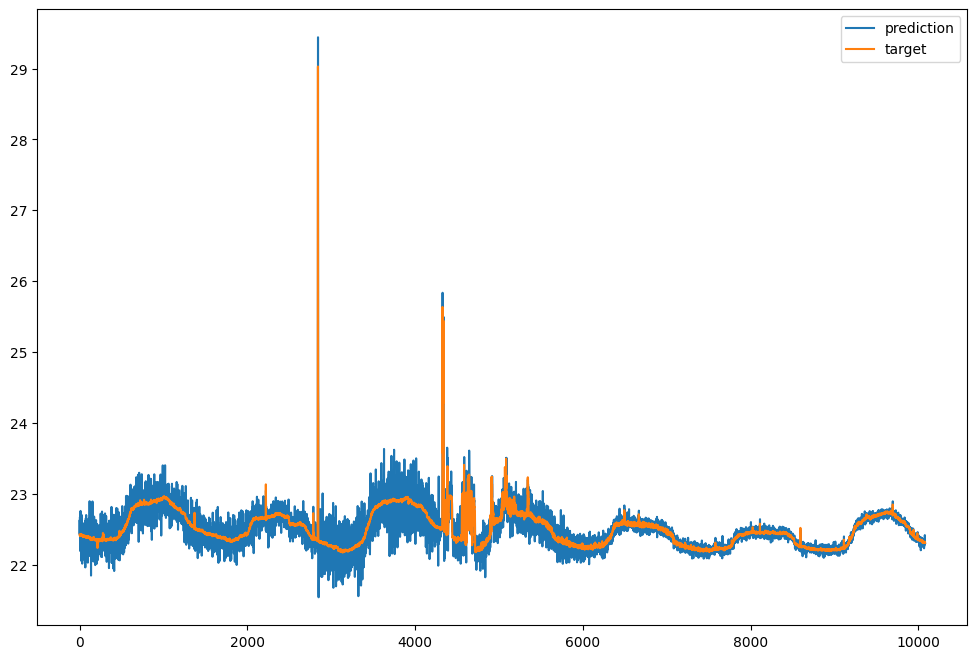

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([22.44675636, 22.62731361, 22.59517479, ..., 22.31527901,
       22.3152771 , 22.30636597])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 0.4245871677994728 %
RMSE 0.15548141300678253
MAPE 0.42465771548449993 %


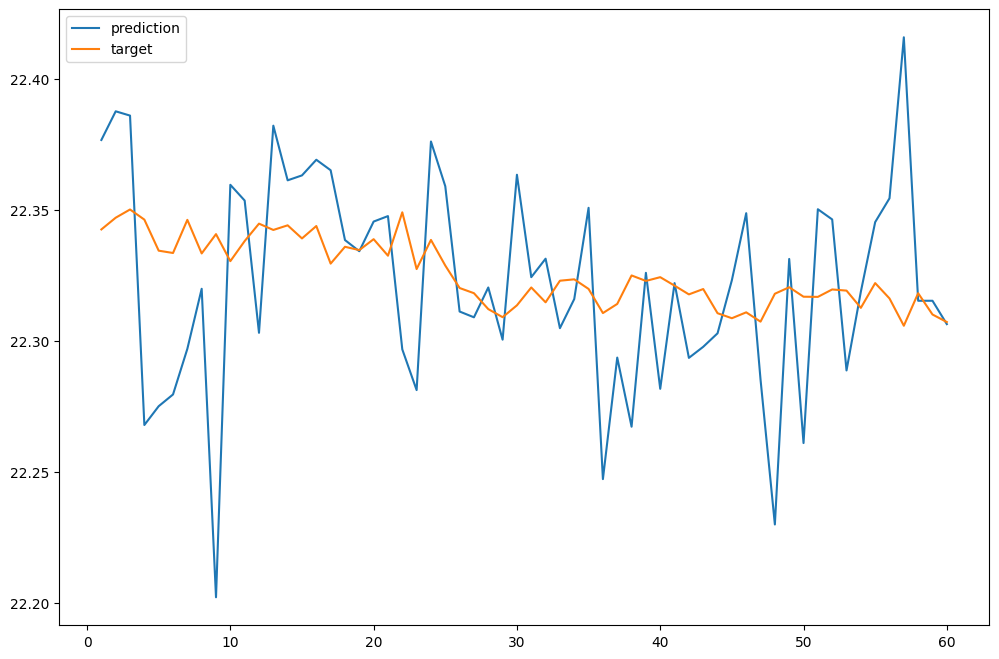

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.40843478840967967